# Selection d'évenement et simulation sans CLM

In [1]:
import numpy as np
import os,glob,struct,shutil,copy
import xarray as xr
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from parflow import Run, read_pfb, write_pfb, ParflowBinaryReader,read_pfb_sequence

## Préparation des forçages

In [3]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Banquettes/simus2D/benchmark/"
wdir = root_dir+'results/'

### lecture des forçages

In [4]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(os.sep.join([root_dir,'forc_bani_5min_2006_2009.txt']),header=None,sep=' ')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2006 00:00:00', periods=len(forc), freq='5min')
P=forc['P']*5*60
forc

SWin      LWin    P         T   WindX  WindY    Press  \
2006-01-01 00:00:00  3.7305  316.1700  0.0  291.1000  0.9565    0.0  98450.0   
2006-01-01 00:05:00  3.7260  316.3100  0.0  291.0508  0.9113    0.0  98450.0   
2006-01-01 00:10:00  3.7215  316.4500  0.0  291.0017  0.8660    0.0  98450.0   
2006-01-01 00:15:00  3.7170  316.5900  0.0  290.9525  0.8208    0.0  98450.0   
2006-01-01 00:20:00  3.7125  316.7300  0.0  290.9033  0.7755    0.0  98450.0   
...                     ...       ...  ...       ...     ...    ...      ...   
2009-12-31 23:10:00 -0.2190  318.3567  0.0  292.3033  0.2318    0.0  98750.0   
2009-12-31 23:15:00 -0.2070  318.2350  0.0  292.1475  0.1910    0.0  98750.0   
2009-12-31 23:20:00 -0.1950  318.1133  0.0  291.9917  0.1502    0.0  98750.0   
2009-12-31 23:25:00 -0.1830  317.9917  0.0  291.8358  0.1093    0.0  98750.0   
2009-12-31 23:30:00 -0.1710  317.8700  0.0  291.6800  0.0685    0.0  98750.0   

                         Hs  
2006-01-01 00:00:00  0.0026  
2006-01-01 00:05:00  0.0026  
2006-01-01 00:10:00  0.0026  
2006-01-01 00:15:00  0.0026  
2006-01-01 00:20:00  0.0026  
...                     ...  
2009-12-31 23:10:00  0.0022  
2009-12-31 23:15:00  0.0022  
2009-12-31 23:20:00  0.0022  
2009-12-31 23:25:00  0.0022  
2009-12-31 23:30:00  0.0022  

[420763 rows x 8 columns]

<AxesSubplot:>

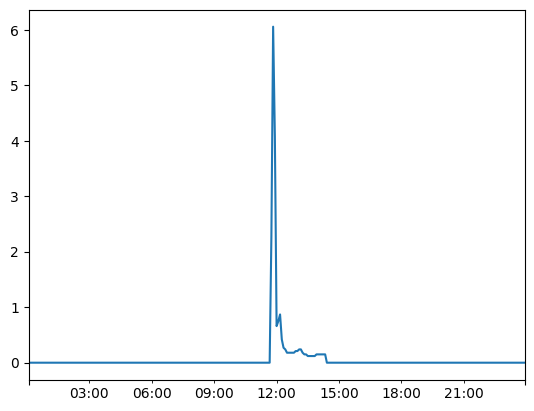

In [16]:
import datetime
P.loc[(P.index>datetime.datetime(2007,7,23)) & (P.index<datetime.datetime(2007,7,24))].plot()

### lecture des évènements

In [5]:
data_evts_file = "/home/hectorb/PARFLOW/PROJECTS/Banquettes/data/evts_banizoumbou_6h_90_21.txt"
data_evts = pd.read_csv(data_evts_file,sep='\t')

In [6]:
data_evts.Starting = data_evts.Starting.apply(lambda x: pd.to_datetime(x))
data_evts.End = data_evts.End.apply(lambda x: pd.to_datetime(x))

### Choix d'évènement

In [7]:
subset = data_evts.loc[(data_evts.Volume>15) & (data_evts.Volume<20) & \
              (data_evts.Starting.dt.year>2006) & (data_evts.Starting.dt.year<2009) &\
              (data_evts.Duration>2.5) & (data_evts.Duration<4.5),:]
subset

Starting                 End  Duration  Volume  Intensity
685 2007-07-23 11:30:00 2007-07-23 14:00:00       3.0   19.46   6.486667
696 2007-08-23 06:30:00 2007-08-23 10:00:00       4.0   19.89   4.972500

In [8]:
pevent = P.loc[(P.index>= subset.Starting.iloc[0]-pd.Timedelta(minutes=20)) & \
      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]

In [9]:
pevent

2007-07-23 11:10:00    0.00
2007-07-23 11:15:00    0.00
2007-07-23 11:20:00    0.00
2007-07-23 11:25:00    0.00
2007-07-23 11:30:00    0.00
2007-07-23 11:35:00    0.00
2007-07-23 11:40:00    0.00
2007-07-23 11:45:00    2.28
2007-07-23 11:50:00    6.06
2007-07-23 11:55:00    4.08
2007-07-23 12:00:00    0.66
2007-07-23 12:05:00    0.75
2007-07-23 12:10:00    0.87
2007-07-23 12:15:00    0.42
2007-07-23 12:20:00    0.27
2007-07-23 12:25:00    0.24
2007-07-23 12:30:00    0.18
2007-07-23 12:35:00    0.18
2007-07-23 12:40:00    0.18
2007-07-23 12:45:00    0.18
2007-07-23 12:50:00    0.18
2007-07-23 12:55:00    0.21
2007-07-23 13:00:00    0.21
2007-07-23 13:05:00    0.24
2007-07-23 13:10:00    0.24
2007-07-23 13:15:00    0.18
2007-07-23 13:20:00    0.15
2007-07-23 13:25:00    0.15
2007-07-23 13:30:00    0.12
2007-07-23 13:35:00    0.12
2007-07-23 13:40:00    0.12
2007-07-23 13:45:00    0.12
2007-07-23 13:50:00    0.12
2007-07-23 13:55:00    0.15
2007-07-23 14:00:00    0.15
2007-07-23 14:05:00 

<AxesSubplot:>

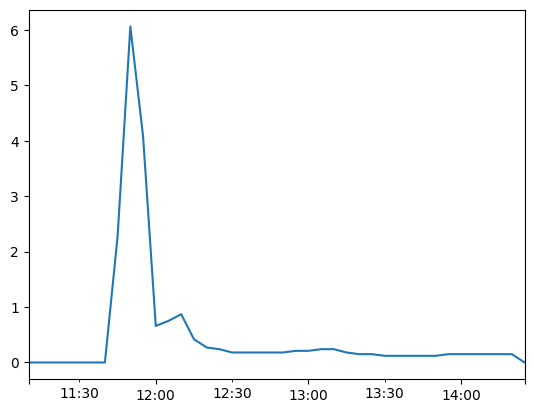

In [981]:
pevent.plot()

modification du hyeto pour test

In [982]:
pevent = pevent*2 + np.roll(pevent.values,10)*2
pevent[0:3]=0

In [984]:
#pevent = pevent*2

Affichage de l'évènement

Volume cumulé:

In [985]:
vol = pevent.sum()
print(vol)

76.91999999999999


<AxesSubplot:>

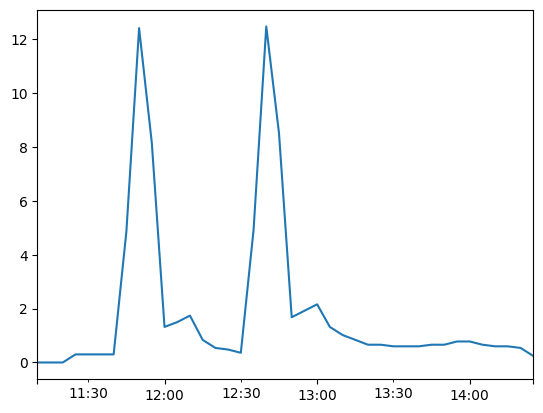

In [986]:
pevent.plot()

## Préparation de la simu

### Chargement des paramètres de simu

In [950]:
hill = Run.from_definition(root_dir+'banq2D.pfidb')

Change le temps d'arrêt de la simu:

In [951]:
hill.TimingInfo.StopTime = pevent.size*5

replace the cycle names and bc values: (recall to recompile parflow changing input_database.h)

In [952]:
hill.Cycle.rain.Names = ' '.join('_%d'%i for i in range(pevent.size))

In [953]:
for i in range(pevent.size):
    hill.Cycle.rain['_%d'%i].Length = 5

hill.Cycle.rain._0.Length

5

In [954]:
hill.Patch.z_upper.BCPressure.Cycle = 'rain'

In [955]:
hill.TimeStep.Value = 5
hill.TimingInfo.DumpInterval = 5

In [956]:
for i in range(pevent.size):
    #mm/10s -> m / s ?
    hill.Patch.z_upper.BCPressure['_%d'%i].Value = -pevent.iloc[i]/1000
hill.Patch.z_upper.BCPressure._0.Value 

-0.0

In [957]:
hill.Mannings.Geom.domain.Value = 0.0000056*60

In [958]:
# option overlandflow "classique" (cinématique):
#hill.Patch.z_upper.BCPressure.Type = 'OverlandKinematic'

# option overlandflow cinématique avec upwinding:
#hill.Patch.z_upper.BCPressure.Type = 'OverlandKinematic'
#hill.Solver.TerrainFollowingGrid.SlopeUpwindFormulation ="Upwind"

# option overlandflow diffusive avec upwinding:
hill.Patch.z_upper.BCPressure.Type = 'OverlandDiffusive'
hill.Solver.TerrainFollowingGrid.SlopeUpwindFormulation ="Upwind"
hill.Solver.OverlandDiffusive.Epsilon = 1E-7

Condition à la limite basse

In [959]:
hill.Patch.z_lower.BCPressure.Type = 'FluxConst'
#hill.Patch.z_lower.BCPressure.RefPatch = 'z_lower'
#hill.Patch.z_lower.BCPressure.RefGeom = 'domain'
hill.Patch.z_lower.BCPressure.Cycle = 'constant'
hill.Patch.z_lower.BCPressure.alltime.Value = 0.0

### Création du dossier de simu et copie de fichiers d'entrées

In [960]:
wdir = root_dir+'results/'
if os.path.exists(wdir):
    shutil.rmtree(wdir)
os.mkdir(wdir)

In [961]:
shutil.copy(root_dir+'slopey.pfb',wdir+'slopey.pfb')

'/home/hectorb/PARFLOW/PROJECTS/Banquettes/simus2D/benchmark/results/slopey.pfb'

In [962]:
hill.Solver.Nonlinear.ResidualTol = 1e-12

In [963]:
hill.dist(wdir+'slopey.pfb')


In [964]:
hill.run(working_directory=wdir,skip_validation=False)


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Banquettes/simus2D/benchmark/results
# ParFlow database
#  - banq2D.pfidb
# ==============================================================================

  Patch:
    z_upper:
      BCPressure:
        Type: OverlandDiffusive ✘
          ★ {'type': 'ERROR', 'message': 'OverlandDiffusive must be one of [DirEquilRefPatch, DirEquilPLinear, FluxConst, FluxVolumetric, PressureFile, FluxFile, OverlandFlow, OverlandFlowPFB, SeepageFace, ExactSolution]'}

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



SystemExit: 1

/home/hectorb/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [965]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01",freq='h'):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files),freq=freq),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [966]:
ds1 = read_and_process_pf_outputs(wdir,date_start=pevent.index[0],freq='1min')
with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
h['dx']

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 30, 'dx': 1.0, 'dy': 0.5, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


1.0

In [967]:
ds1 = ds1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
ds1 = ds1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
ds1 = ds1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

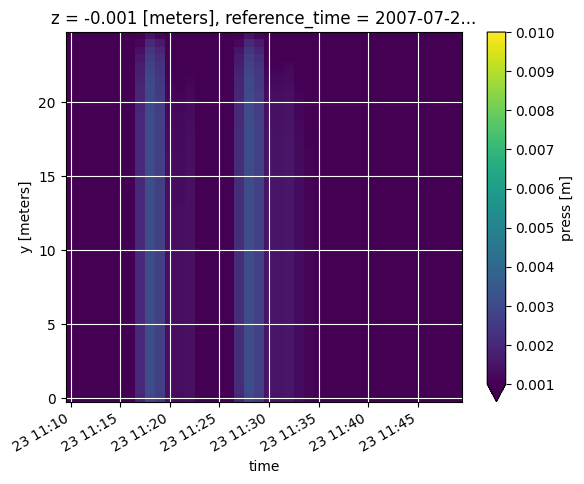

In [968]:
ds1.press.isel(z=0).plot(x='time',vmax=0.01,vmin =0.001)
plt.gca().grid(True, which='major', axis='both', color='w')


In [969]:
ds1 = ds1.assign(grady = lambda x: x.press.differentiate(coord="y"))

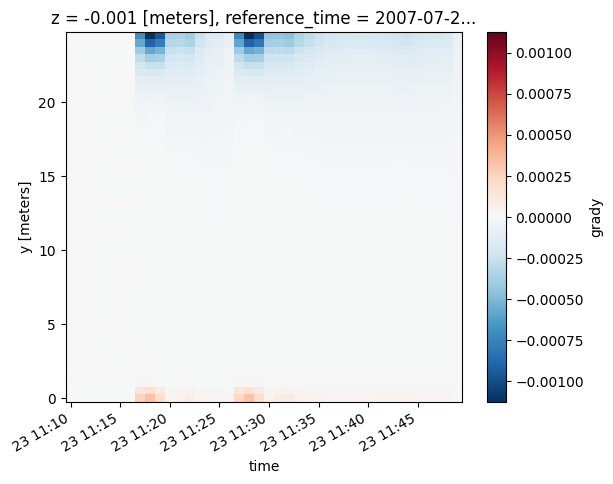

In [970]:
ds1.grady.isel(z=0).plot(x='time')

In [971]:
ds1.overlandsum.min()

<xarray.DataArray 'overlandsum' ()>
array(0.)
Coordinates:
    reference_time  datetime64[ns] 2007-07-23T11:10:00

In [972]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [973]:
h['dy']

0.5

In [974]:
manning = hill.Mannings.Geom.domain.Value
ds1 = ds1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.press.data[:,0,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         h['dx'],h['dy'],manning)))
ds1.Q.attrs['units']='m3/timestep'
ds1 = ds1.assign(Qmm = lambda x: x.Q/h['dx']/h['nx']/h['dy']/h['ny']*1000)

/tmp/ipykernel_7748/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


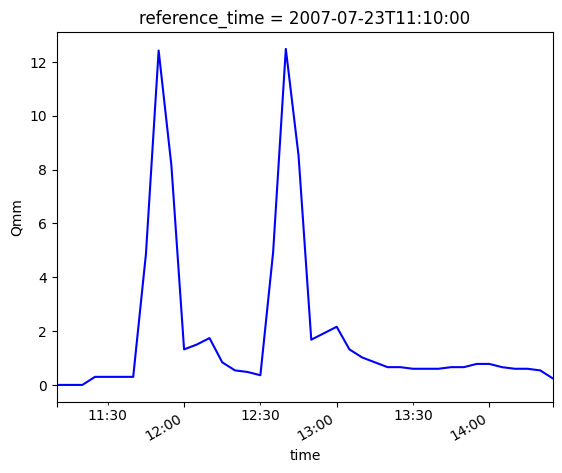

In [975]:
fig, ax = plt.subplots(1,1)
pevent.plot(ax=ax,color='b')
ds1.Qmm.plot(ax=ax,color = 'k')


In [976]:
Ke = 100*ds1.Qmm.sum()/vol
print("Ke = %2.2f %%"%Ke)

Ke = 8.46 %


In [977]:
ds1.Qmm.sum()

<xarray.DataArray 'Qmm' ()>
array(6.50551279)
Coordinates:
    reference_time  datetime64[ns] 2007-07-23T11:10:00

In [978]:
storage = ds1.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['nx']/h['dy']/h['ny']
storage = storage - storage[0]

In [979]:
storage

time
2007-07-23 11:10:00    0.000000e+00
2007-07-23 11:11:00    0.000000e+00
2007-07-23 11:12:00   -9.094947e-13
2007-07-23 11:13:00    1.500000e+00
2007-07-23 11:14:00    3.000000e+00
2007-07-23 11:15:00    4.500000e+00
2007-07-23 11:16:00    6.000000e+00
2007-07-23 11:17:00    1.025191e+01
2007-07-23 11:18:00    1.333288e+01
2007-07-23 11:19:00    1.478131e+01
2007-07-23 11:20:00    1.517704e+01
2007-07-23 11:21:00    1.677719e+01
2007-07-23 11:22:00    1.842240e+01
2007-07-23 11:23:00    1.953957e+01
2007-07-23 11:24:00    2.073169e+01
2007-07-23 11:25:00    2.203205e+01
2007-07-23 11:26:00    2.323604e+01
2007-07-23 11:27:00    2.612994e+01
2007-07-23 11:28:00    2.842889e+01
2007-07-23 11:29:00    2.931945e+01
2007-07-23 11:30:00    2.932515e+01
2007-07-23 11:31:00    3.053245e+01
2007-07-23 11:32:00    3.179953e+01
2007-07-23 11:33:00    3.269988e+01
2007-07-23 11:34:00    3.370393e+01
2007-07-23 11:35:00    3.473699e+01
2007-07-23 11:36:00    3.574154e+01
2007-07-23 11:37:00    

In [ ]:
storage.plot()